In [4]:
%%writefile reachability.py
from safety import minInitCons, largest_fixpoint
from math import inf
class PositiveReachability(minInitCons):
    """Compute energy needed to safely reach target set T with
    probability > 0.
    
    Expressed as largest fixpoint of a Bellman-style equation.
    The value of the action chooses a successor that we rely on
    for reaching the target and that has minimal value. The value
    of this successor is the energy needed to safely reach T via this
    successor + the safe energy level from the possibly-reached target
    state, or the energy needed to survive in some other successor
    under the action, whatever is higher.
    
    `targets` : `set of ints` target states
    """

    def __init__(self, mdp, targets, cap = inf):
        super(PositiveReachability, self).__init__(mdp, cap)

        self.targets = targets
        self.pos_reach_values = None

    def get_positive_reachability(self):
        """A Bellman-style equation largest fixpoint solver.

        We start with ∞ for every state and propagate the safe energy
        needed to reach T from the target states further.
        """
        self.get_safe_values()
        print(self.safe_values)

        def reload_capper(s, v):
            # +1 handles cases when self.cap is ∞
            if v >= self.cap+1:
                return inf
            if self.is_reload(s):
                return 0
            return v

        # Initialize:
        #  * safe_value for target states
        #  * inf otherwise
        self.pos_reach_values = [inf] * self.states
        for t in self.targets:
            self.pos_reach_values[t] = self.safe_values[t]

        largest_fixpoint(self.mdp, self.pos_reach_values,
                         self.action_value_T,
                         value_adj=reload_capper,
                         # Target states are always safe_values[t]
                         skip_state=lambda x: x in self.targets)
        return self.pos_reach_values

    def action_value_T(self, a, values):
        """Compute value of action basd on curent values pf `r`

        `target_values` = array with values that applies for `r(t)` if `t`
                          satisfies `target_cond`. Equal to self.safe_values
                          if not given.
        """
        # Initialization
        candidate = inf
        succs = a.distr.keys()

        for t in succs:
            survivals = [self.safe_values[s] for s in succs if s != t]
            current_v = values[t]
            t_v = max([current_v] + survivals)

            if t_v < candidate:
                candidate = t_v
            #print(f"{a.src} -- {a.label} -> {t}:{t_v}")
        return candidate + a.cons

Overwriting reachability.py


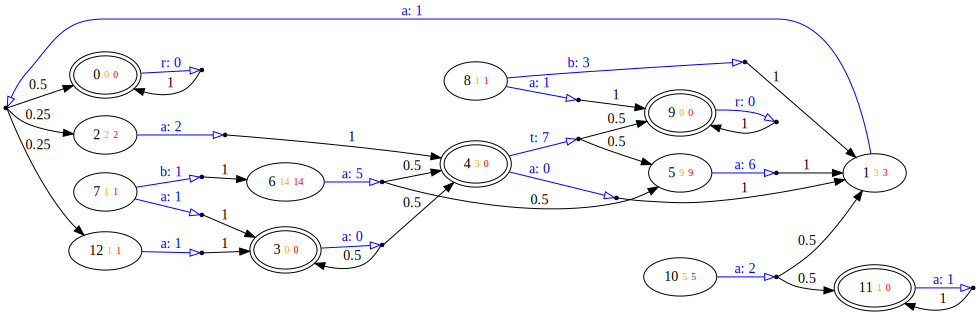

In [2]:
%run Kucera-example.ipynb
T = set([9])
targets = [True if s in T else False for s in range(m.num_states)]
m.add_action(4, {9:.5, 5:.5}, "t", 7)
m.show("SM")

In [3]:
from reachability import PositiveReachability
pr = PositiveReachability(m, T, 22)
pr.get_positive_reachability()

[0, 3, 2, 0, 0, 9, 14, 1, 1, 0, 5, 0, 1]


[inf, 3, 2, 0, 0, 9, 14, 1, 1, 0, 5, inf, 1]